## Initial Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.kinetics import Kinetics400

from IPython.display import Video
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Path.ls = lambda x: [o.name for o in x.iterdir()]

### Video Transformations from [`pytorch/vision/references/video_classification/transforms.py` ](https://github.com/pytorch/vision/blob/master/references/video_classification/transforms.py)

In [2]:
import torch
import random


def crop(vid, i, j, h, w):
    return vid[..., i:(i + h), j:(j + w)]


def center_crop(vid, output_size):
    h, w = vid.shape[-2:]
    th, tw = output_size

    i = int(round((h - th) / 2.))
    j = int(round((w - tw) / 2.))
    return crop(vid, i, j, th, tw)


def hflip(vid):
    return vid.flip(dims=(-1,))


# NOTE: for those functions, which generally expect mini-batches, we keep them
# as non-minibatch so that they are applied as if they were 4d (thus image).
# this way, we only apply the transformation in the spatial domain
def resize(vid, size, interpolation='bilinear'):
    # NOTE: using bilinear interpolation because we don't work on minibatches
    # at this level
    scale = None
    if isinstance(size, int):
        scale = float(size) / min(vid.shape[-2:])
        size = None
    return torch.nn.functional.interpolate(
        vid, size=size, scale_factor=scale, mode=interpolation, align_corners=False)


def pad(vid, padding, fill=0, padding_mode="constant"):
    # NOTE: don't want to pad on temporal dimension, so let as non-batch
    # (4d) before padding. This works as expected
    return torch.nn.functional.pad(vid, padding, value=fill, mode=padding_mode)


def to_normalized_float_tensor(vid):
    return vid.permute(3, 0, 1, 2).to(torch.float32) / 255


def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std


# Class interface

class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    @staticmethod
    def get_params(vid, output_size):
        """Get parameters for ``crop`` for a random crop.
        """
        h, w = vid.shape[-2:]
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, vid):
        i, j, h, w = self.get_params(vid, self.size)
        return crop(vid, i, j, h, w)


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return center_crop(vid, self.size)


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return resize(vid, self.size)


class ToFloatTensorInZeroOne(object):
    def __call__(self, vid):
        return to_normalized_float_tensor(vid)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, vid):
        return normalize(vid, self.mean, self.std)


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, vid):
        if random.random() < self.p:
            return hflip(vid)
        return vid


class Pad(object):
    def __init__(self, padding, fill=0):
        self.padding = padding
        self.fill = fill

    def __call__(self, vid):
        return pad(vid, self.padding, self.fill)


## Constructing the Dataset 

Using `torchvision.datasets.kinetics.Kinetics400`

In [3]:
base_dir = Path('/home/rahul/github_projects/video-classification/')
data_dir = base_dir/'data'

In [4]:
!tree {data_dir/'train'}

/home/rahul/github_projects/video-classification/data/train
├── class1
│   ├── c1-sample1.mp4
│   └── c1-sample2.mp4
└── class2
    ├── c2-sample1.mp4
    └── c2-sample2.mp4

2 directories, 4 files


In [5]:
data = Kinetics400(data_dir/'train',
                   step_between_clips = 1,
                   extensions         = ('mp4',),
                   frames_per_clip    = 32,
                   frame_rate = None)

  0%|          | 0/1 [00:00<?, ?it/s]/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


In [6]:
data[0][0].shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


torch.Size([32, 900, 1600, 3])

## Seeing the Data to Understand What Exactly is in the Training Data

### Helper Functions

In [7]:
def get_metadata(data):
    """
    Takes in a `Kinetics400` dataset, computes the no. of frames in each data point
    and returns in a DataFrame
    
    Parameters
    ----------
    data : torchvision.datasets.kinetics.Kinetics400
        A `Kinetics400` like video dataset (Kinetics400 can be used as a cookie
        cutter for any standard video dataset)
        
    Returns
    -------
    metadata : pd.DataFrame
        A dataframe listing the names, no. of frames, FPS, and no. of subclips create for each video 
        in the dataset.
            * The `# Subclips` column tells us which video's sample will be returned when we index
              into the dataset like so: `data[0]`
        
    """
    fnames     = [f.rsplit('/')[-1] for f in data.metadata['video_paths']]
    num_frames = [len(pts) for pts in data.metadata['video_pts']]
    fps        = [i for i in data.metadata['video_fps']]
    subclips   = [len(x) for x in data.video_clips.clips]

    metadata = pd.DataFrame(list(zip(fnames, num_frames, fps, subclips)),
                            columns = ['Filename', '# Frames', 'FPS', '# Subclips'])
    print(f'Length of the dataset --> {len(data)}')
    return metadata

In [8]:
def plot_img(sub_plt, x, i):
    """
    Plot one frame of a 4D video tensor.
    Removes axes and prints Frame # for aesthetic peace of mind
    
    Parameters
    ----------
    
    sub_plt : matplotlib.figure.Figure
        One subplot of `plt.subplots`
    
    x : 4D torch.Tensor or np.array
        Must be of shape (T, H, W, C) (T = num frames)
        
    i : int
        Frame no. that is to be plotted
        
    """
    sub_plt.imshow(x[i])
    sub_plt.set_title(f'Frame #{i+1}')
    sub_plt.axis('off')

In [9]:
def plot_adjacent(x, figsize=(8,5), i1=0, i2=31):
    """
    Plot 2 frames of a video tensor side by side
    
    Parameters
    ----------
    
    x : 4D torch.Tensor or np.array
        Must be of shape (T, H, W, C) (T = num frames)
    
    i1, i2 : int
        Indices of the frames to be plotted
    """
    f, plots = plt.subplots(1, 2, figsize=figsize)
    plots[0] = plot_img(plots[0], x, i1)
    plots[1] = plot_img(plots[1], x, i2)

    f.tight_layout()

### Seeing the Training Data

<br>
When the dataset of class `Kinetics400` is constructed with `frames_per_clip = 32`, it doesn't take into consideration any data points which have less than 32 clips. <br>

As seen in the DataFrame above, `c2-sample1` and `c2-sample2` had less than 32 frames, and `[len(x) for x in data.video_clips.clips]` reveals that 0 samples were taken from both these clips. 

For `c1-sample1`, which has exactly 32 clips, one clip gets created, whereas for `c1-sample2`, 16 clips get created, leading to a dataset of `len = 17`. The dataset has 1 sample from `c1-sample1` and 16 samples from `c1-sample2`.

<br>

In [10]:
get_metadata(data)

Length of the dataset --> 17


,Filename,# Frames,FPS,# Subclips
0,c1-sample1.mp4,32,25.0,1
1,c1-sample2.mp4,47,25.0,16
2,c2-sample1.mp4,17,25.0,0
3,c2-sample2.mp4,13,25.0,0


---
<h3> Below are the actual videos

In [11]:
Video('../data/train/class1/c1-sample1.mp4', width=400)

In [12]:
Video('../data/train/class1/c1-sample2.mp4', width=400)

In [13]:
Video('../data/train/class2/c2-sample1.mp4', width=400)

In [14]:
Video('../data/train/class2/c2-sample2.mp4', width=400)

<br>

To fully understand what's happening, look at the first and last frames of selected data samples (indices 0, 1, 2 and 16) below.

<br>

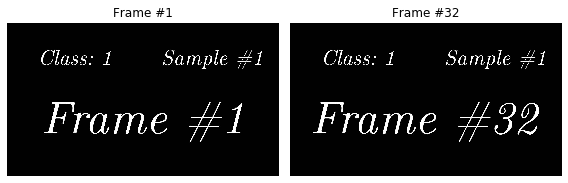

In [15]:
plot_adjacent(data[0][0])

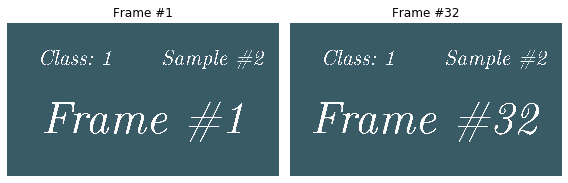

In [16]:
plot_adjacent(data[1][0])

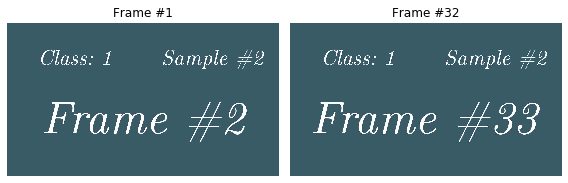

In [17]:
plot_adjacent(data[2][0])

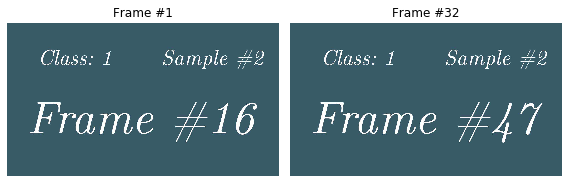

In [18]:
plot_adjacent(data[16][0])

<br>

---

## Data Augmentations -- Albumentations

In [19]:
import os
import numpy as np
from skimage.color import label2rgb

import albumentations as A
import random

### Read Video as `Torch Tensor`

This isn't nearly as efficient as `torchvision`'s video reader but is useful to quickly read in a video as a `torch.Tensor` for experiments.

In [20]:
file = '../data/train/class1/c1-sample1.mp4'

In [21]:
def read_video_tensor(filename, probe_i=1):
    """
    Read a file as a 4D numpy tensor with shape (T,H,W,C) (T=num_frames)
    
    Parameters
    ----------
    filename : str
        Path to the video file
        
    probe_i : int
        Index of `ffmpeg.probe(file)['streams']` to extract the video's
        height and width. Usually works as `1` but if the file has no
        audio, you might need to use `0`.
        
    """
    import ffmpeg

    out, _ = (
        ffmpeg
        .input(file)
        .output('pipe:', format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True)
    )

    meta = ffmpeg.probe(file)['streams'][probe_i]
    height, width = meta['height'], meta['width']
    #height, width = 900, 1600

    vid = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1, height, width, 3])
    )

    return torch.from_numpy(vid)

In [22]:
vid = read_video_tensor(file, probe_i=0)
vid.shape

torch.Size([32, 900, 1600, 3])

### Albumentations on a Single Frame

<br>

`x` is one data sample i.e. a `tensor` of 32 frames/images. To apply albumentations, we'll first apply it on one single frame, then loop and apply over all the frames. As seen below, _not all_ `albumentations` can be applied to `torch.Tensor`s, so they first need to be converted to `np.array`. However, this is a good thing because the `albumentations` always work faster on `np.array` vs. `torch.Tensor`

In [23]:
x = data[3][0]
x.shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


torch.Size([32, 900, 1600, 3])

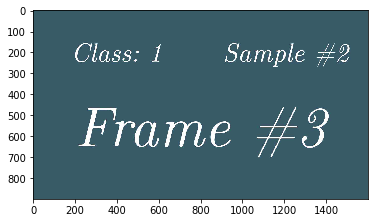

In [24]:
plt.imshow(x[0])

In [25]:
def show(aug, img):
    img = aug(image = img)['image']
    plt.figure(figsize=(6,6))
    plt.imshow(img)

CPU times: user 203 ms, sys: 8.53 ms, total: 211 ms
Wall time: 31.2 ms


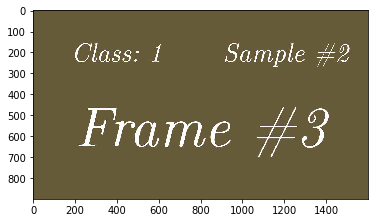

In [26]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), np.asarray(x[0]))

In [27]:
for i in x: print(i.shape)

torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])


CPU times: user 394 ms, sys: 20.4 ms, total: 414 ms
Wall time: 53 ms


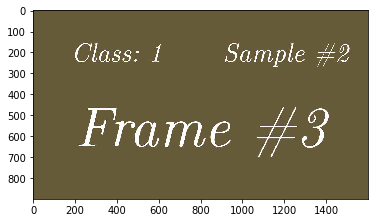

In [28]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), x[0])

CPU times: user 233 ms, sys: 16.2 ms, total: 250 ms
Wall time: 28.5 ms


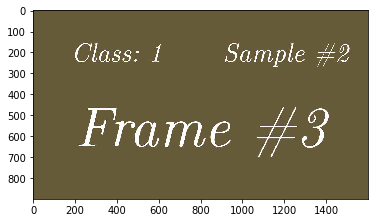

In [29]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), np.asarray(x[0]))

In [30]:
%%time

random.seed(42)
show(A.ToGray(p=1), x[0])

TypeError: Expected Ptr<cv::UMat> for argument '%s'

CPU times: user 213 ms, sys: 13.8 ms, total: 227 ms
Wall time: 28.8 ms


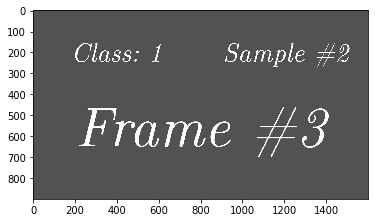

In [31]:
%%time

random.seed(42)
show(A.ToGray(p=1), np.asarray(x[0]))

### Albumentations on a Video i.e. List of Frames

<br>

Here, I define a function `aug_video` which applies a list of `albumentations` to a video. It ensures that the exact same transformation is applied to each frame of the video. This is a must because, for instance, you wouldn't want one frame of the video to be horizontally flipped while the next not. This is done using a constant `random.seed()` value.

In [32]:
file = '../data/tennis.mp4'

In [33]:
vid = read_video_tensor(file)
vid.shape

torch.Size([42, 1080, 1920, 3])

In [34]:
import ffmpeg

out, _ = (
    ffmpeg
    .input(file)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)

meta = ffmpeg.probe(file)['streams'][1]
height, width = meta['height'], meta['width']

vid = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

In [35]:
vid.shape

(42, 1080, 1920, 3)

In [36]:
tfms = A.Compose([
    A.HorizontalFlip(p=0.0),
    #A.ToGray(p=1),
    #A.CLAHE(p=1),
    A.Cutout(p=1),
    A.RandomRain(p=1),
    #A.ChannelDropout(p=1),
    #A.ChannelShuffle(p=1),
    #A.InvertImg(p=1)
])

In [37]:
def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

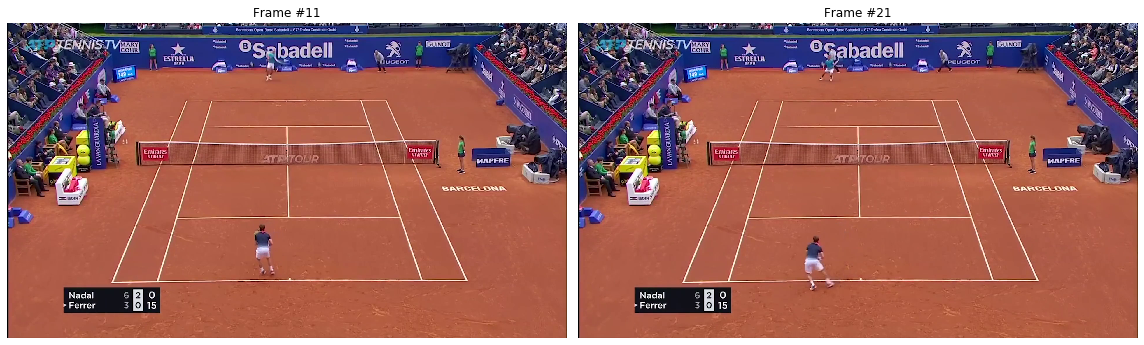

In [38]:
plot_adjacent(vid, figsize=(16, 9), i1=10, i2=20)

torch.Size([42, 1080, 1920, 3])

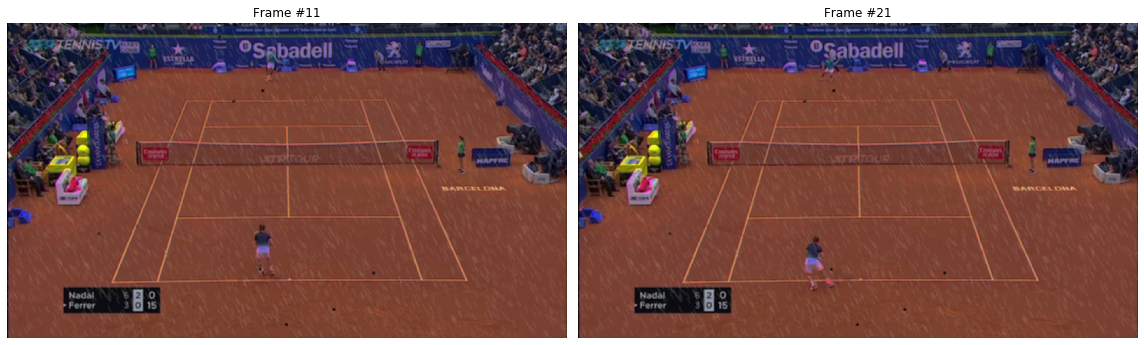

In [39]:
vidaug = (aug_video(vid, tfms))
vidaug.shape
plot_adjacent(vidaug, figsize=(16, 9), i1=10, i2=20)

In [40]:
vid.shape

(42, 1080, 1920, 3)

### Testing to see if the `ToFloatTensorInZeroOne` and `Normalize` from the torchvision Video Transforms can be incorporated in the same `Compose` list as `albumentations`


In [41]:
tmp = torch.from_numpy(vid)
tmp.shape

torch.Size([42, 1080, 1920, 3])

In [42]:
to_normalized_float_tensor(tmp).shape

torch.Size([3, 42, 1080, 1920])

In [43]:
tmp.shape[-2:]

torch.Size([1920, 3])

In [44]:
def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std

mean = [0.43216, 0.394666, 0.37645]
std  = [0.22803, 0.22145, 0.216989]

In [45]:
shape = (-1,) + (1,) * (tmp.dim() - 1)
shape

(-1, 1, 1, 1)

In [46]:
torch.as_tensor(mean).shape

torch.Size([3])

In [47]:
# in the official code
(torch.as_tensor(mean).reshape(shape)).shape

torch.Size([3, 1, 1, 1])

In [48]:
# recreating to see if same result can be optained with `C` axis at end instead of beginning
torch.as_tensor(mean)[..., None, None, None].shape

torch.Size([3, 1, 1, 1])

In [49]:
torch.as_tensor(mean)[None, None, None].shape

torch.Size([1, 1, 1, 3])

In [50]:
raw_shape = (tmp/255. - torch.as_tensor(mean)[None, None, None])
raw_shape.shape

torch.Size([42, 1080, 1920, 3])

In [51]:
test_target = to_normalized_float_tensor(tmp) - torch.as_tensor(mean).reshape(shape)
test_target.shape

torch.Size([3, 42, 1080, 1920])

In [52]:
to_normalized_float_tensor(raw_shape).shape == test_target.shape

True

In [53]:
to_normalized_float_tensor(raw_shape) == test_target

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

---

### Combining Torchvision Normalising and Albumentations

<br>

**They can't** be combined in one `Compose`(or it's too painful to make it happen). <br>
Instead, in the following chunk of `__getitem__` function of `Kinetics400`...

```python
if self.transform is not None:
    video = self.transform(video) 
```

... we can pass in only the normalisation functions, and then add another line to call the `albumentations` transformations, like so:

```python
if self.transform is not None:
    video = self.transform(video) # Torchvision `ToFloatTensorInZeroOne` and `Normalize`. Returns shape (C,T,H,W)
    video = self.tfms_albumentations(video) # Albumentations Transforms
```

In order to do so, we'll need to tweak the `aug_video` function defined in the above section to `permute` to the appropriate shape `(T,H,W,C)`, and after the `albumentations` transforms are done, `permute` back to shape `(C,T,H,W)`

In [54]:
tfms_torch = torchvision.transforms.Compose([
    ToFloatTensorInZeroOne(),
    Normalize(mean=[0.43216, 0.394666, 0.37645],
              std=[0.22803, 0.22145, 0.216989])
])

In [55]:
tfms_torch(vidaug).shape

torch.Size([3, 42, 1080, 1920])

In [56]:
tfms_torch(vidaug).permute(1,2,3,0).shape

torch.Size([42, 1080, 1920, 3])

Redefine `aug_video` for combining both kinds of transformations -- accomodate changing sizes

In [57]:
def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    vid = vid.permute(1,2,3,0) # added line of code
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid)).permute(3,0,1,2)

In [58]:
def combine_tfms(vid, tfms_torch, tfms_albu):
    if not isinstance(vid, torch.Tensor): vid = torch.from_numpy(vid)
    return aug_video(tfms_torch(vid), tfms_albu)

In [59]:
tfms_albu = A.Compose([
    A.HorizontalFlip(p=1),
    A.ChannelShuffle(p=1)
])

In [60]:
vid.shape

(42, 1080, 1920, 3)

In [61]:
combined = combine_tfms(vid, tfms_torch, tfms_albu)
combined.shape

torch.Size([3, 42, 1080, 1920])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


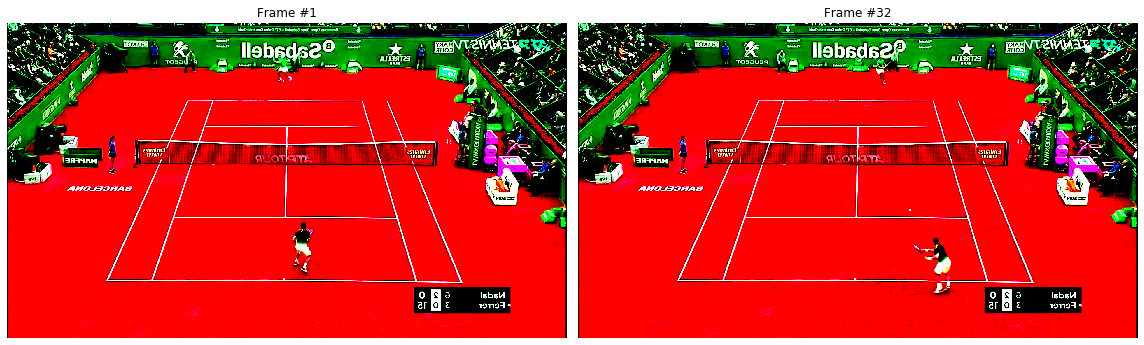

In [62]:
plot_adjacent(combined.permute(1,2,3,0), figsize=(16,10))

## Understanding Samplers -- RandomClipSampler

### Setup

In [63]:
from torchvision.datasets.samplers import *

In [64]:
??RandomClipSampler

In [65]:
data

Dataset Kinetics400
    Number of datapoints: 17
    Root location: /home/rahul/github_projects/video-classification/data/train

In [66]:
max_clips_per_video = 3
sampler = RandomClipSampler(data.video_clips, max_clips_per_video)

In [67]:
for x in sampler: print(x)

7
8
0
6


### Understanding `RandomClipSampler`'s   `__iter__`

In [68]:
len(data.video_clips.clips)

# no. of subclips of each video in the dataset
# the `x` below actualls contains the `pts` i.e. 
# timestamps (of ffmpeg's unit) i.e. indexes of frames of the video
[x.shape for x in data.video_clips.clips] 

4

[torch.Size([1, 32]),
 torch.Size([16, 32]),
 torch.Size([0, 32]),
 torch.Size([0, 32])]

In [69]:
torch.randperm(16)[:3] + 0

tensor([ 5, 11, 14])

In [70]:
idxs = []
s = 0 # counter for ensuring the idxs returned are for the correct video in the dataset

# select at most max_clips_per_video for each video, randomly
for i,c in enumerate(data.video_clips.clips):
    print(f'\n--------------------- Data sample # {i} ---------------------')
    length = len(c)
    print(f'No. of subclips per video in the dataset    [length]  --> {length}')
    size = min(length, max_clips_per_video)
    print(f'No. of clips that will be sampled per video [size]    --> {size}')
    # `+ s` ensures that the indexes are returned for the correct video
    sampled = torch.randperm(length)[:size] + s
    #print(f's = {s}')
    print(f'Which of the {length} subclips will be returned   [sampled] --> {sampled}')
    s += length
    idxs.append(sampled)


--------------------- Data sample # 0 ---------------------
No. of subclips per video in the dataset    [length]  --> 1
No. of clips that will be sampled per video [size]    --> 1
Which of the 1 subclips will be returned   [sampled] --> tensor([0])

--------------------- Data sample # 1 ---------------------
No. of subclips per video in the dataset    [length]  --> 16
No. of clips that will be sampled per video [size]    --> 3
Which of the 16 subclips will be returned   [sampled] --> tensor([6, 2, 9])

--------------------- Data sample # 2 ---------------------
No. of subclips per video in the dataset    [length]  --> 0
No. of clips that will be sampled per video [size]    --> 0
Which of the 0 subclips will be returned   [sampled] --> tensor([], dtype=torch.int64)

--------------------- Data sample # 3 ---------------------
No. of subclips per video in the dataset    [length]  --> 0
No. of clips that will be sampled per video [size]    --> 0
Which of the 0 subclips will be returned   

In [71]:
idxs = torch.cat(idxs)
print(f'List of indexes to pull from the dataset                    -->  {idxs.tolist()}')

perm = torch.randperm(len(idxs))
idxs = idxs[perm].tolist()

print(f'The sampler returns a randomised version of the above list  -->  {idxs}')

List of indexes to pull from the dataset                    -->  [0, 6, 2, 9]
The sampler returns a randomised version of the above list  -->  [6, 0, 2, 9]


## Playing around with Fastai

In [72]:
%reload_ext autoreload
%autoreload 2

In [73]:
from fastai.vision import *

In [74]:
DataBunch??

In [75]:
Learner??

In [76]:
??cnn_learner

In [77]:
??DataBunch

In [78]:
??Collection

In [80]:
dt = DataBunch(train_dl=torch.utils.data.DataLoader(data, sampler = sampler), valid_dl=torch.utils.data.DataLoader(data, sampler = sampler))
dt

DataBunch;

Train: Dataset Kinetics400
    Number of datapoints: 17
    Root location: /home/rahul/github_projects/video-classification/data/train;

Valid: Dataset Kinetics400
    Number of datapoints: 17
    Root location: /home/rahul/github_projects/video-classification/data/train;

Test: None

In [81]:
dt.show_batch()

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


ValueError: too many values to unpack (expected 2)

In [82]:
torch.hub.list("moabitcoin/ig65m-pytorch")

Using cache found in /home/rahul/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


['r2plus1d_34_32_ig65m',
 'r2plus1d_34_32_kinetics',
 'r2plus1d_34_8_ig65m',
 'r2plus1d_34_8_kinetics']

In [87]:
model = torch.hub.load("moabitcoin/ig65m-pytorch", "r2plus1d_34_32_ig65m", num_classes=359, pretrained=True)
model.fc.out_features = len(data.classes)

Using cache found in /home/rahul/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [88]:
learn = Learner(data=dt, model=model, loss_func=nn.CrossEntropyLoss())

modify `fastai/fastai/basic_train.py` and comment out this line to prevent callback (it isn't designed to work with video)
```python
    100                 xb, yb = cb_handler.on_batch_begin(xb, yb)
```

In [ ]:
learn.lr_find()